In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray, rgb2hed
from skimage.filters import threshold_otsu, threshold_multiotsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import dilation, erosion, disk, opening, closing, area_closing, area_opening
from skimage.exposure import equalize_hist
from skimage.measure import regionprops
from skimage.measure import label
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Importing the data

In [411]:
train_df = pd.read_csv("train_metadata.csv")
test_df = pd.read_csv("test_metadata.csv")

train_files = train_df["ID"].to_list()
labels_train = train_df["label"].to_list()
label_dict = dict(zip(train_df["ID"], train_df["label"]))
test_files = test_df["ID"].to_list()

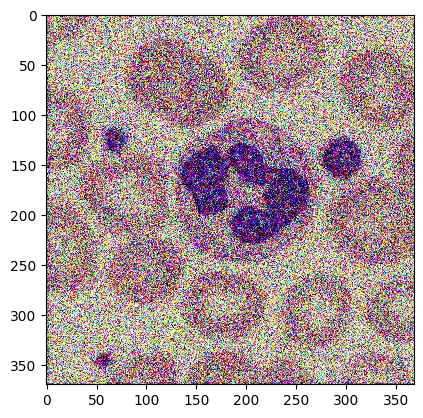

In [368]:
# Verifying if everything works
train_idx = np.random.randint(0, len(train_files))
X = io.imread(f"./train/{train_files[train_idx]}")
plt.imshow(X)

## Data Enhancement

## Segmentation #1 : Watershed (bad) 

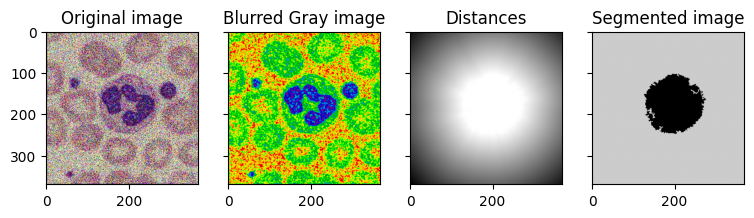

In [369]:
X_smooth = ndi.gaussian_filter(rgb2gray(X), 1.0)
def select_cell(X):
    thresh = threshold_otsu(X)
    X_mask = X > thresh
    X_mask = remove_small_objects(X_mask, min_size=5000)
    X_mask = remove_small_holes(X_mask, area_threshold=6500)
    distance = ndi.distance_transform_edt(X_mask)
    coords = peak_local_max(distance, footprint=np.ones((1, 1), dtype=bool), labels = X_mask.astype(bool))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=X_mask)
    return labels, distance

labels,distance = select_cell(X_smooth)
fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(X_smooth, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Blurred Gray image')
ax[2].imshow(-distance, cmap=plt.cm.gray)
ax[2].set_title('Distances')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Segmented image')

plt.show()

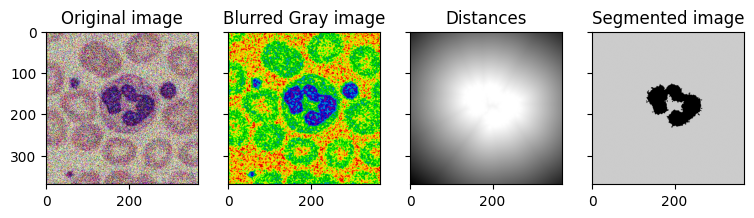

In [370]:
def select_nucleus(X):
    thresh = threshold_otsu(X)
    X_mask = X > 0.4
    X_mask = remove_small_objects(X_mask, min_size=5000)
    X_mask = remove_small_holes(X_mask, area_threshold=6500)
    distance = ndi.distance_transform_edt(X_mask)
    coords = peak_local_max(distance, footprint=np.ones((1, 1), dtype=bool), labels = X_mask.astype(bool))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=X_mask)
    return labels, distance

labels_nucleus, distance_nucleus = select_nucleus(X_smooth)
fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(X_smooth, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Blurred Gray image')
ax[2].imshow(-distance_nucleus, cmap=plt.cm.gray)
ax[2].set_title('Distances')
ax[3].imshow(labels_nucleus, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Segmented image')

plt.show()

## Segmentation #2 : Multi-thresh Otsu Method

[0.37724338 0.59201293]


(np.float64(-0.5), np.float64(367.5), np.float64(369.5), np.float64(-0.5))

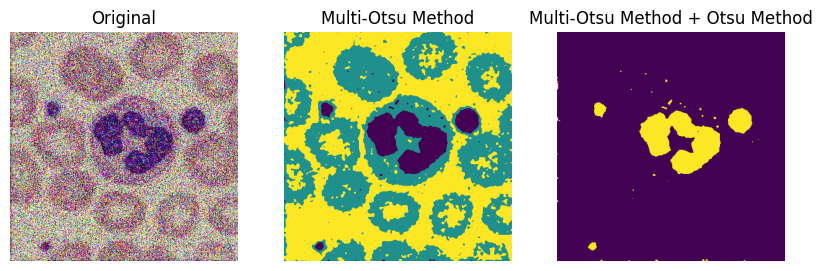

In [371]:
X_smooth = ndi.gaussian_filter(rgb2gray(X), 1.8)
threshs = threshold_multiotsu(X_smooth, classes=3)
regions = np.digitize(X_smooth, bins=threshs)
print(threshs)

thresh2 = threshold_otsu(regions)
nucleus = (regions < thresh2).astype(float)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

ax[0].imshow(X, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(regions)
ax[1].set_title('Multi-Otsu Method')
ax[1].axis('off')

ax[2].imshow(nucleus)
ax[2].set_title('Multi-Otsu Method + Otsu Method')
ax[2].axis('off')

We managed to correclty segment the nucleus. It's time to segment the rest of the cell.

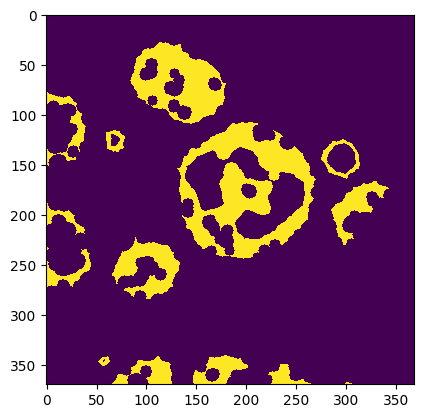

In [372]:
cell_mask = (dilation(regions, disk(5))==1)
labels_cell = label(cell_mask)

nucleus_bool = nucleus.astype(bool)
nucleus_bool = nucleus_bool

touching = np.unique(labels_cell[nucleus_bool])
touching = touching[touching!=0]
white_blood_cell = np.isin(labels_cell, touching)

plt.imshow(white_blood_cell)


(np.float64(-0.5), np.float64(367.5), np.float64(369.5), np.float64(-0.5))

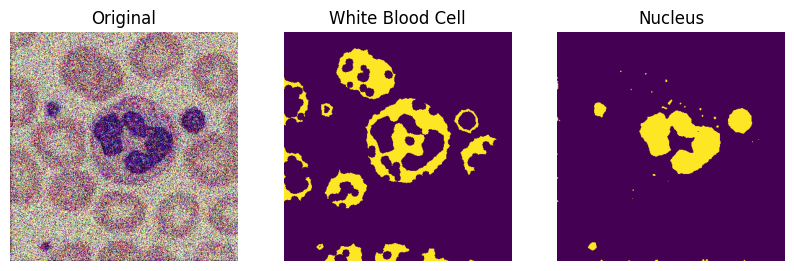

In [373]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

ax[0].imshow(X, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(white_blood_cell)
ax[1].set_title('White Blood Cell')
ax[1].axis('off')

ax[2].imshow(nucleus)
ax[2].set_title('Nucleus')
ax[2].axis('off')

(np.float64(-0.5), np.float64(367.5), np.float64(369.5), np.float64(-0.5))

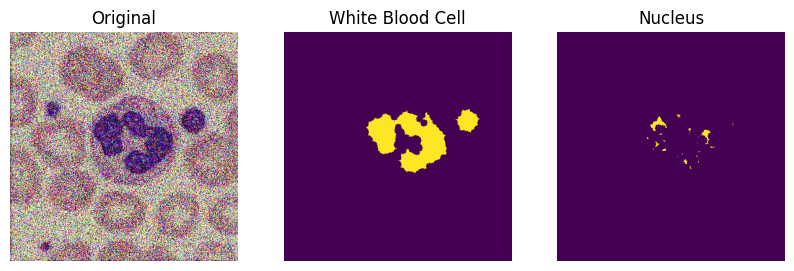

In [374]:
def multi_otsu_method(X):
    ihc_hed = rgb2hed(ndi.gaussian_filter(X, 1.0))
    nuclei_channel = ihc_hed[:, :, 0] # Canal Hématoxyline

    thresholds = threshold_multiotsu(nuclei_channel, classes=3)
    regions = np.digitize(nuclei_channel, bins=thresholds)
    regions = erosion(regions, disk(5))

    white_cell_mask = (regions > 0) 
    nucleus_mask = (regions > 1)

    labels_cell = label(white_cell_mask)

    touching = np.unique(labels_cell[nucleus_mask])
    touching = touching[touching!=0]
    white_blood_cell = np.isin(labels_cell, touching)
    return white_blood_cell, nucleus_mask

white_blood_cell, nucleus_mask=multi_otsu_method(X)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

ax[0].imshow(X, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(white_blood_cell)
ax[1].set_title('White Blood Cell')
ax[1].axis('off')

ax[2].imshow(nucleus_mask)
ax[2].set_title('Nucleus')
ax[2].axis('off')

In [375]:
def extract_features(white_blood_cell, nucleus_mask):
    cell_props = regionprops(white_blood_cell.astype(int))
    if len(cell_props) == 0:
        return {
            'area_ratio': 0,
            'cell_eccentricity': 0,
            'num_lobes': 0,
            'nucleus_circularity': 0
        }
    cell_props = max(cell_props, key=lambda x: x.area)
    conv_comp_nucleus = label(nucleus_mask)
    nuc_props = regionprops(conv_comp_nucleus.astype(int))
    nuc_total_area = sum([prop.area for prop in nuc_props])
    num_lobes = len(nuc_props)

    features = {
        'area_ratio': nuc_total_area/cell_props.area,
        'cell_eccentricity': cell_props.eccentricity,
        'num_lobes': num_lobes,
        ''
        'nucleus_circularity': (4 * np.pi * nuc_total_area) / (cell_props.perimeter ** 2) if cell_props.perimeter > 0 else 0
    }
    return features

In [ ]:
features_list = []
labels_list = []

train_idxs=np.random.randint(0, len(train_files), len(train_files))
training_size = int(0.8*len(train_idxs))
print("Extracting features ----")
for train_idx in tqdm(train_idxs, desc="Extracting... "):
    X = io.imread(f"./train/{train_files[train_idx]}")
    white_blood_cell, nucleus_mask = multi_otsu_method(X)
    labelX = label_dict[train_files[train_idx]]
    feats = extract_features(white_blood_cell, nucleus_mask)
    features_list.append(feats)
    labels_list.append(labelX)

Extracting features ----


Extracting... : 100%|██████████| 28901/28901 [18:16<00:00, 26.36it/s] 


In [399]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')

In [405]:
X_train, X_valid, y_train, y_valid=train_test_split(features_list, labels_list, test_size=0.2, random_state=0)
df_features = pd.DataFrame(X_train)
clf.fit(df_features, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [406]:
validation_features = pd.DataFrame(X_valid)
y_pred=clf.predict(validation_features)

In [407]:
Conf = confusion_matrix(y_valid, y_pred)
print(Conf)

[[  44    8    0    0   25    0    1    0    0    0    0    2    0]
 [   4  306    0    0   80    2   10    0    0    0    3   13    1]
 [   0    0   37    0    4    0    2    0    0    0    0   28    0]
 [   0    0    0  108    3    1    1    0    0    0    0   69    0]
 [   3   40    1    1 1484    0   34    0    0    0    0   53    1]
 [   0    0    0    0    3   32    6    2    0    0    0   21    0]
 [   0   15    0    1   66    1  433    0    0    0    1   59    0]
 [   0    0    0    1   15    1    7   43    0    0    0   23    1]
 [   0    1    0    0    5    0    1    0    4    0    0    2    0]
 [   0    0    0    0    3    0    0    0    0    2    0    0    0]
 [   1    2    0    0    3    0    3    0    0    0   14    2    0]
 [   0   13    3    5   43    2   41    1    0    0    0 2456    0]
 [   0    4    0    0   13    0    6    0    0    0    0    3   48]]


In [408]:
def f1score(Conf):
    metrics = {}
    for k in range(len(Conf)):
        TP = Conf[k,k]
        FN = Conf[k,:].sum()-TP
        FP = Conf[:,k].sum()-TP
        TN = Conf.sum()-(TP+FN+FP)
        metrics[k]={
            "TP":TP,
            "FN":FN,
            "FP":FP,
            "TN":TN
        }

    precision=[metrics[k]["TP"]/(metrics[k]["TP"]+metrics[k]["FP"]) for k in range(len(Conf))]
    recall = [metrics[k]["TP"]/(metrics[k]["TP"]+metrics[k]["FN"]) for k in range(len(Conf))]

    F1score = [2*precision[k]*recall[k]/(precision[k]+recall[k]) for k in range(len(Conf))]
    return np.mean(F1score)
print(f1score(Conf))

0.7001838535210554


In [414]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
def train(features_list, labels_list):
    df_features = pd.DataFrame(features_list)
    clf.fit(df_features, labels_list)

def extract_test(test_files):
    features_list=[]
    for indx in tqdm(range(len(test_files))):
        X = io.imread(f"./test/{test_files[indx]}")
        white_blood_cell, nucleus_mask = multi_otsu_method(X)
        feats = extract_features(white_blood_cell, nucleus_mask)
        features_list.append(feats)
    return features_list

def test(features_test):
    y_pred = clf.predict(pd.DataFrame(features_test))
    test_df["label"] = y_pred
    test_df.to_csv('submission.csv', index=False)

train(features_list, labels_list)
features_test=extract_test(test_files)


100%|██████████| 9634/9634 [08:53<00:00, 18.07it/s]


In [415]:
test(features_test)